# Exercise Biocath

Attached a pickle file with 3 lists in the following order: [X_train, Y_train, X_test]. 

Q: Our objective is to classify, where the class 1 is the minority class and we would like to detect as many of it with as little fp. How would you tackle this question? The construction of some of the features is quit rigid, but others depend on some factors which can be reconsider or changed a bit. Which features would be most helpful to improve?

# Discussion

There is a number of ways to deal with imbalance. each technique has its pros & cons, and ob course its limit.
First I'll do simple things, display how I understand the data, and then use the "big guns".

##### Classification with boosting or bagging
Bagging and Boosting are similar in that they are both ensemble techniques, where a set of weak learners are combined to create a strong learner that obtains better performance than a single one. Also, they can be used to improve the accuracy of Classification & Regression Trees.

##### Undersampling
Select a subsample of the sets of zeros such that it's size matches the set of ones. There is an obvious loss of information, unless you use a more complex framework (for a instance, I would split the first set on 9 smaller, mutually exclusive subsets, train a model on each one of them and ensemble the models).

##### Oversampling
Produce artificial ones until the proportion is 50%/50%. My previous employer used this by default. There are many frameworks for this (I think SMOTE is the most popular, but I prefer simpler tricks like Noisy PCA).

##### One Class Learning
Just assume your data has a few real points (the ones) and lots of random noise that doesn't physically exists leaked into the dataset (anything that is not a one is noise). Use an algorithm to denoise the data instead of a classification algorithm.

##### Cost-Sensitive Training
Use a asymmetric cost function to artificially balance the training process.

# Solution 

Importing data from file

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pickle

with open("exercise_to_sahar.p", "rb") as f:
    dump = pickle.load(f)
    X_train_original,Y_train_original,X_test_original = dump[0], dump[1], dump[2]

Understand the data

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

def get_report(a,b):
    target_names = ['class 0', 'class 1']
    return classification_report(a, b, target_names=target_names)

print(get_report(Y_train_original,Y_train_original))    


             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00    799300
    class 1       1.00      1.00      1.00       700

avg / total       1.00      1.00      1.00    800000



Split the data into train&test datasets

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.array(X_train_original), np.array(Y_train_original),train_size=0.8,test_size=0.2,random_state=0)


# Classification with 'non-complex' models

In [4]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import SGDClassifier

def classify_and_report(clf):
    clf.fit(X_train,y_train)
    print(get_report(y_test,clf.predict(X_test)))

##### Classification with LR

In [5]:
lrcv = LogisticRegressionCV(n_jobs=-1)
classify_and_report(lrcv)

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00    159859
    class 1       0.85      0.29      0.43       141

avg / total       1.00      1.00      1.00    160000



##### Classification with SGD

In [6]:
sgdc = SGDClassifier(n_jobs=-1, max_iter=1000)
classify_and_report(sgdc)

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00    159859
    class 1       1.00      0.09      0.17       141

avg / total       1.00      1.00      1.00    160000



## Classifications with Encemble


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier


##### Classiffication with RF

In [8]:
rfc = RandomForestClassifier(n_jobs=-1,warm_start=True)
classify_and_report(rfc)

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00    159859
    class 1       0.83      0.34      0.48       141

avg / total       1.00      1.00      1.00    160000



##### Classiffication with RF & Bagging

In [9]:
n_estimators = 10

clf = OneVsRestClassifier(BaggingClassifier(rfc, max_samples=1.0 / n_estimators, n_estimators=n_estimators))
classify_and_report(clf)

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00    159859
    class 1       0.91      0.14      0.25       141

avg / total       1.00      1.00      1.00    160000



##### Classiffication with xgboost

In [10]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_jobs=-1,max_delta_step=0.1)
classify_and_report(xgb)

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00    159859
    class 1       0.88      0.10      0.18       141

avg / total       1.00      1.00      1.00    160000



# Feature Importance
of course there is an different importance for each feature.  
let's have a look

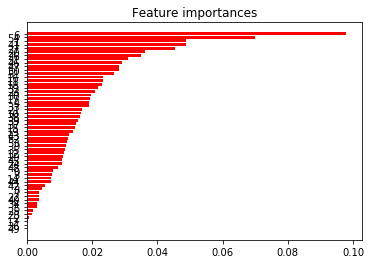

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

importances = rfc.feature_importances_
estimators = rfc.estimators_
num_features = rfc.n_features_

# std = np.std([importances for tree in estimators],axis=0)
indices = np.argsort(importances)

plt.figure()
plt.title("Feature importances")
plt.barh( range(num_features), importances[indices],color="r",align="center")
         
plt.yticks( range(num_features), indices)
plt.show()

In [27]:
number_of_feature_to_print = 5
importance = pd.DataFrame(importances, index=range(num_features),columns=["Importance"])
importance.nlargest(number_of_feature_to_print,'Importance')

,Importance
6,0.097769
54,0.070013
1,0.048785
41,0.048651
27,0.045247


there is a big difference between the feature. and these 5 features have the most impact on the data.

# Weighted Sample Classes
increace importance of the minory class.

In [28]:
sample_weights = np.array([1 if i == 0 else 5 for i in y_train])

def classify_and_report_weighted(clf):
    clf.fit(X_train,y_train,sample_weight=sample_weights)
    print(get_report(y_test,clf.predict(X_test)))

In [29]:
rfc_weighted = RandomForestClassifier(n_jobs=-1,warm_start=True)
classify_and_report_weighted(rfc_weighted)

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00    159859
    class 1       0.75      0.33      0.46       141

avg / total       1.00      1.00      1.00    160000



In [30]:
xgb_weighted = XGBClassifier(n_jobs=-1,max_delta_step=0.1)
classify_and_report_weighted(xgb_weighted)

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00    159859
    class 1       0.90      0.13      0.23       141

avg / total       1.00      1.00      1.00    160000



Got bettter results - but not good enough!

# Split techniques

I could use split techniques and try to work around the imbalanced.  
but UnderSampling and OverSampling techniques will probably have higher percision&recall, due to the small proportion of the classes, and the very small amount of samples of the minority class.

# with Imbalance Learn package

Using a scatter plot od 2D to better understand the data and the classes.  
Will try the use of sampling techniques to make the data less imbalanced, and then check if is had a good effect on the classification task.   
(BTD randomize concept won't work obviously)


In [33]:
from matplotlib import pyplot as plt
import pandas as pd
import imblearn

df = pd.DataFrame(X_train_original)
df['target'] = Y_train_original

def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [34]:
print(df.target.value_counts())

0    799300
1       700
Name: target, dtype: int64


#### Reduce to 2D
Because the dataset has many features and our graphs will be 2D,  
I'll use dimension reduction on the features using Principal Component Analysis(PCA):

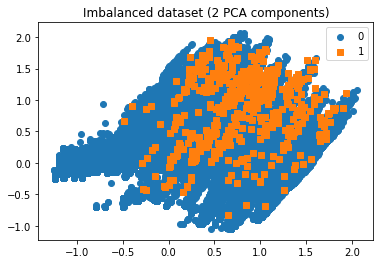

In [35]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(df.loc[:, df.columns != 'target'])
y = df.target

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')

##### will split the data as always...

In [36]:
X_imb_train, X_imb_test, y_imb_train, y_imb_test = train_test_split(X, y,train_size=0.8,test_size=0.2,random_state=0)

print(get_report(y_imb_train,y_imb_train))

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00    639441
    class 1       1.00      1.00      1.00       559

avg / total       1.00      1.00      1.00    640000



### Under-Sampling with TomekLinks

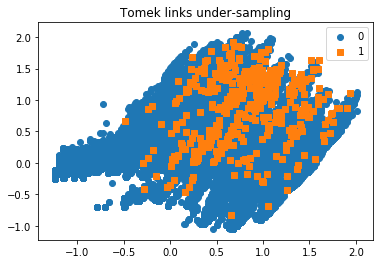

In [39]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=False, ratio='majority')

X_tl, y_tl = tl.fit_sample(X_imb_train, y_imb_train)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

In [40]:
from sklearn.ensemble import RandomForestClassifier
sample_weights = np.array([1 if i == 0 else 5 for i in y_tl])

rfc_weighted_balanced = RandomForestClassifier(n_jobs=-1,warm_start=True)
rfc_weighted_balanced.fit(X_tl,y_tl,sample_weight=sample_weights)

print(get_report(y_imb_test,rfc_weighted_balanced.predict(X_imb_test)))

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00    159859
    class 1       0.43      0.09      0.15       141

avg / total       1.00      1.00      1.00    160000



Not good. lets try somthing else...

### Over-sampling followed by under-sampling

~ Over-sampling: SMOTE  
~ Under-sampling: Tomek links

C:\Users\SaharMilis\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'k' is deprecated from 0.2 and will be removed in 0.4. Use 'k_neighbors' instead.
  category=DeprecationWarning)
C:\Users\SaharMilis\Anaconda3\lib\site-packages\imblearn\utils\deprecation.py:50: DeprecationWarning: 'm' is deprecated from 0.2 and will be removed in 0.4. Use 'm_neighbors' instead.
  category=DeprecationWarning)


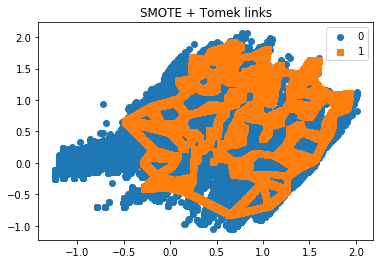

In [41]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='minority',n_jobs=-1)
X_smt, y_smt = smt.fit_sample(X_imb_train, y_imb_train)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

In [42]:
sample_weights = np.array([1 if i == 0 else 5 for i in y_smt])

rfc_weighted_balanced = RandomForestClassifier(n_jobs=-1,warm_start=True)
rfc_weighted_balanced.fit(X_smt,y_smt,sample_weight=sample_weights)

print(get_report(y_smt,y_smt))
print(get_report(y_smt,rfc_weighted_balanced.predict(X_smt)))

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00    639082
    class 1       1.00      1.00      1.00    639082

avg / total       1.00      1.00      1.00   1278164

             precision    recall  f1-score   support

    class 0       0.99      0.99      0.99    639082
    class 1       0.99      0.99      0.99    639082

avg / total       0.99      0.99      0.99   1278164



###### Success!

# Prediction

predict the X_test from the objective.



In [48]:
model = rfc_weighted_balanced
trans = pca

def predict_classify(X):
        return model.predict(trans.transform(X))    
    

In [50]:
y_predict = predict_classify(X_test_original)

### I'm a pickle

In [53]:
with open('predict.pickle', 'wb') as handle:
    pickle.dump(y_predict,handle)